## Human ectoparasite model for Barcelona 1490

#### Import packages

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
#from pymc.Matplot import plot
import scipy.stats

#### Import observed data

In [2]:
barcelona_1490 = np.array([1,0,1,1,0,1,5,3,1,0,1,1,2,3,5,0,6,3,6,3,8,1,5,2,1,1,2,2,2,5,7,12,4,3,5,3,8,5,8,8,6,12,11,22,15,14,24,14,15,20,20,13,11,25,28,30,24,28,42,24,32,24,27,31,34,33,29,31,38,40,42,38,53,44,66,52,53,56,63,49,60,57,65,55,55,47,67,62,65,57,47,46,62,54,52,48,49,64,46,67,52,50,56,46,41,38,36,39,31,32,41,25,32,35,36,36,33,26,42,31,19,27,23,22,15,24,32,19,10,16,12,15,14,13,12,13,12,6,12,15,5,9,3,5,12,6,7,3,3,3,3,2,3,3,0,3,2,3,3,1,1,4,2,3,0,2,3,2,0,1,1,4,1,2,2,1,1,2,0,1,1,2])
mortality_data = barcelona_1490
t = len(mortality_data)

#### Set up the model

In [3]:
__all__ = ['mortality_data', 'beta_1','beta_2','beta_h', 'gamma', 'sigma', 'mu', 'lice_index', 
           'E_0', 'I_0', 'R_0', 'D_0', 'D_h',
           'pop_size', 'sus_frac',
           'mortality', 'mortality_sim']

#Parameters
beta_1 = pm.Uniform('beta_1', 1e-9, .05)
beta_2 = pm.Uniform('beta_2', 1e-9, 1.)
beta_h = 0.05
sigma = 1/8.
gamma = 1/2.
mu = .6
lice_index = 15.0
pop_size = 25000.0
sus_frac = pm.Uniform('sus_frac', 1e-9, 1.)

#Initial conditions
S_0 = pop_size*sus_frac
I1_0 = pm.Uniform('I1_0', 1., 10.)
I2_0 = 2.
R_0 = 0.
D_0 = 1.

#SIIRD + vector model for human ectoparasite plague
@pm.deterministic
def SIRD(S_0=S_0, I1_0=I1_0, I2_0=I2_0, R_0=R_0, D_0=D_0, 
         beta_1=beta_1, beta_2=beta_2, beta_h=beta_h, 
         gamma=gamma, sigma=sigma, lice_index=lice_index):
    S_h = np.zeros(t)
    I1_h = np.zeros(t)
    I2_h = np.zeros(t)
    R_h = np.zeros(t)
    D_h = np.zeros(t)
    
    S_v= np.zeros(t)
    I_v = np.zeros(t)
    
    S_h[0] = S_0
    I1_h[0] = I1_0
    I2_h[0] = I2_0
    R_h[0] = R_0
    D_h[0] = D_0
    
    S_v[0] = lice_index*(S_0+R_0)
    I_v[0] = lice_index*I1_0

    for i in range(1, t):
        N_h = S_h[i-1] + I1_h[i-1] + I2_h[i-1] + R_h[i-1]
        
        new_I1 = min(S_h[i-1], beta_h*S_h[i-1]*I_v[i-1]/N_h)
        new_I2_and_R = min(I1_h[i-1], sigma*I1_h[i-1])
        new_I2 = mu*new_I2_and_R
        new_recovered = new_I2_and_R - new_I2
        new_dead = min(I2_h[i-1], gamma*I2_h[i-1])

        S_h[i] = S_h[i-1] - new_I1
        I1_h[i] = I1_h[i-1] + new_I1 - new_I2_and_R
        I2_h[i] = I2_h[i-1] + new_I2 - new_dead
        R_h[i] = R_h[i-1] + new_recovered
        D_h[i] = new_dead

        lice_K = lice_index*N_h
        if (S_v[i-1]+I_v[i-1]/lice_K) < 1:
            lice_births = 0.111*S_v[i-1]*(1-(S_v[i-1]+I_v[i-1])/lice_K)
        elif (S_v[i-1]+I_v[i-1]/lice_K) > 1:
            lice_births = 0.

        new_I1_infected_lice = beta_1*S_v[i-1]*I1_h[i-1]/N_h
        new_I2_infected_lice = beta_2*S_v[i-1]*I2_h[i-1]/N_h
        new_removed_lice = 0.33*I_v[i-1]

        new_infected_lice = min(S_v[i-1],((beta_1*S_v[i-1]*I1_h[i-1]/N_h) + (beta_2*S_v[i-1]*I2_h[i-1]/N_h)))
        new_removed_lice = 0.33*I_v[i-1]

        S_v[i] = S_v[i-1] + lice_births - new_infected_lice
        I_v[i] = I_v[i-1] + new_infected_lice - new_removed_lice
        
    return S_h,I1_h,I2_h,R_h,D_h,S_v,I_v

D_h = pm.Lambda('D_h', lambda SIRD=SIRD: SIRD[4])

#Likelihood
mortality = pm.Poisson('mortality', mu=D_h, value=mortality_data, observed=True)
mortality_sim = pm.Poisson('mortality_sim', mu=D_h)

#### Fit the model

In [4]:
if True:#__name__ == '__main__':
    vars = [mortality_data, beta_1, beta_2, beta_h, sigma, mu, gamma, lice_index, 
            I1_0, I2_0, R_0, D_0, D_h,
            sus_frac,mortality, mortality_sim]
    
    mc = pm.MCMC(vars, db='pickle', dbname='ectoparasite')
    mc.use_step_method(pm.AdaptiveMetropolis, [beta_1, beta_2, sus_frac, I1_0])
    mc.sample(iter=5000, burn=2000, thin=1, verbose=0)
    mc.sample(iter=5000, burn=2000, thin=1, verbose=0)
    mc.sample(iter=5000, burn=2000, thin=1, verbose=0)
    mc.db.close()

 [-----------------100%-----------------] 5001 of 5000 complete in 74.8 sec

#### Output summary

In [5]:
pm.gelman_rubin(mc)

AttributeError: module 'pymc' has no attribute 'gelman_rubin'

In [6]:
mc.summary()

[53.815 58.782]
	56.619           1.301            0.104            [54.542 59.464]
	57.224           1.321            0.106            [55.117 60.3  ]
	57.726           1.338            0.108            [54.987 60.298]
	58.12            1.354            0.11             [55.869 61.319]
	58.403           1.368            0.112            [56.004 61.5  ]
	58.573           1.379            0.113            [56.091 61.589]
	58.626           1.388            0.115            [56.114 61.481]
	58.562           1.394            0.116            [56.001 61.327]
	58.382           1.397            0.117            [55.743 61.038]
	58.086           1.398            0.118            [55.439 60.748]
	57.676           1.395            0.118            [54.922 60.186]
	57.154           1.39             0.118            [54.358 59.621]
	56.525           1.381            0.118            [53.839 59.159]
	55.792           1.37             0.118            [53.097 58.401]
	54.962           1.356         

In [7]:
M = pm.MAP(mc)
M.fit()
M.BIC

KeyboardInterrupt: 

#### Plot the posteriors

In [ ]:
%matplotlib inline
plot(mc)

#### Plot the fit

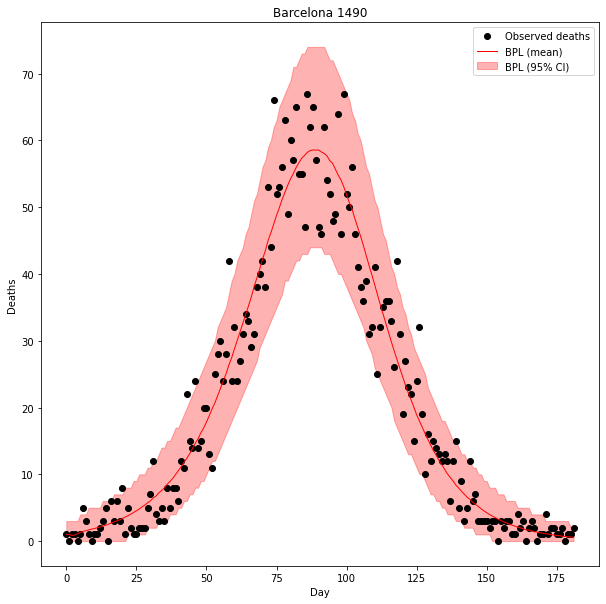

In [9]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.title('Barcelona 1490')
plt.xlabel('Day')
plt.ylabel('Deaths')
plt.plot(mortality_data, 'o', mec='black', color='black', label='Observed deaths')
plt.plot(mortality_sim.stats()['mean'], color='red', linewidth=1, label='BPL (mean)')
y_min = mortality_sim.stats()['quantiles'][2.5]
y_max = mortality_sim.stats()['quantiles'][97.5]
plt.fill_between(range(0,len(mortality_data)), y_min, y_max, color='r', alpha=0.3, label='BPL (95% CI)')
plt.legend()
plt.savefig('barcelona_1490_bpl.png')